In [1]:
!pip install "ray[tune]"

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [125]:
import pandas as pd
import numpy as np

pd.options.display.width = 200
pd.options.display.max_columns = 20

# Import Almond.csv
almond: pd.DataFrame = pd.read_csv('Almond.csv')
almond.columns = ['idx', 'len', 'wid', 'thk', 'area', 'perim', 'round', 'solid', 'compact', 'aspect', 'eccent', 'extent', 'convex', 'type']

#=============== PREPROCESSING ===============#

# Remove useless/redundant cols
# almond = almond.drop(['idx', 'round', 'aspect', 'eccent'], axis=1)
almond = almond.drop(['idx'], axis=1)
almond['round'].fillna(almond['round'].mean())
almond['aspect'].fillna(almond['aspect'].mean())
almond['eccent'].fillna(almond['eccent'].mean())

print("-"*50 + " almond " + "-"*50)
print(almond.head(n=20))

# Isolate len, wid, thk cols + convert to numeric
dims: pd.DataFrame = almond[['len', 'wid', 'thk']]

# Convert to numeric
dims = dims.apply(pd.to_numeric, errors='coerce')

# Replace missing values with -1
dims = dims.fillna(-1)

# Create one-hot encoding for missing values
dimsOneHot = dims.copy()
dimsOneHot[dimsOneHot != -1] = 0
dimsOneHot[dimsOneHot == -1] = 1
dimsOneHot.columns = ['len1H', 'wid1H', 'thk1H']

print("-"*50 + " dims " + "-"*50)
print(dims.head(n=20))

print("-"*50 + " dimsOneHot " + "-"*50)
print(dimsOneHot.head(n=20))

# Sort within row + delete first col (empty after sort)
dimsSorted: pd.Series = dims.apply(np.sort, axis=1)
dims = pd.DataFrame(dimsSorted.values.tolist(), index=dimsSorted.index, columns=['null', 'len', 'wid'])
dims = dims[['len', 'wid']]

# Replace len, wid, thk cols in almond with sorted values
almond[['len', 'wid']] = dims
almond.drop('thk', axis=1, inplace=True)

# Insert one-hot encoding for missing values
almond.insert(2, 'thk1H', dimsOneHot['thk1H'])
almond.insert(2, 'wid1H', dimsOneHot['wid1H'])
almond.insert(2, 'len1H', dimsOneHot['len1H'])
almond[['len1H', 'wid1H', 'thk1H']] = dimsOneHot

# Convert area, perim, solid, compact, extent, convex to numeric
almond[['area', 'perim', 'solid', 'compact', 'extent', 'convex']] = almond[['area', 'perim', 'solid', 'compact', 'extent', 'convex']].apply(pd.to_numeric)

# Convert type to one-hot encoding
typeOneHot = pd.get_dummies(almond['type'])
typeOneHot.columns = ['mamra', 'regular', 'sanora']
# almond = almond.drop('type', axis=1)
# almond = almond.join(typeOneHot.astype(float))

# Split to X, Y
# Y = almond['type']
X = almond.drop('type', axis=1).astype(float)
Y = typeOneHot.astype(float)

# Print fully preprocessed dataset
print("-"*50 + " Inputs (X) - fully preprocessed " + "-"*50)
print(X)
print("-"*50 + " Targets (Y) - fully preprocessed " + "-"*50)
print(Y)

ValueError: could not convert string to float: ''

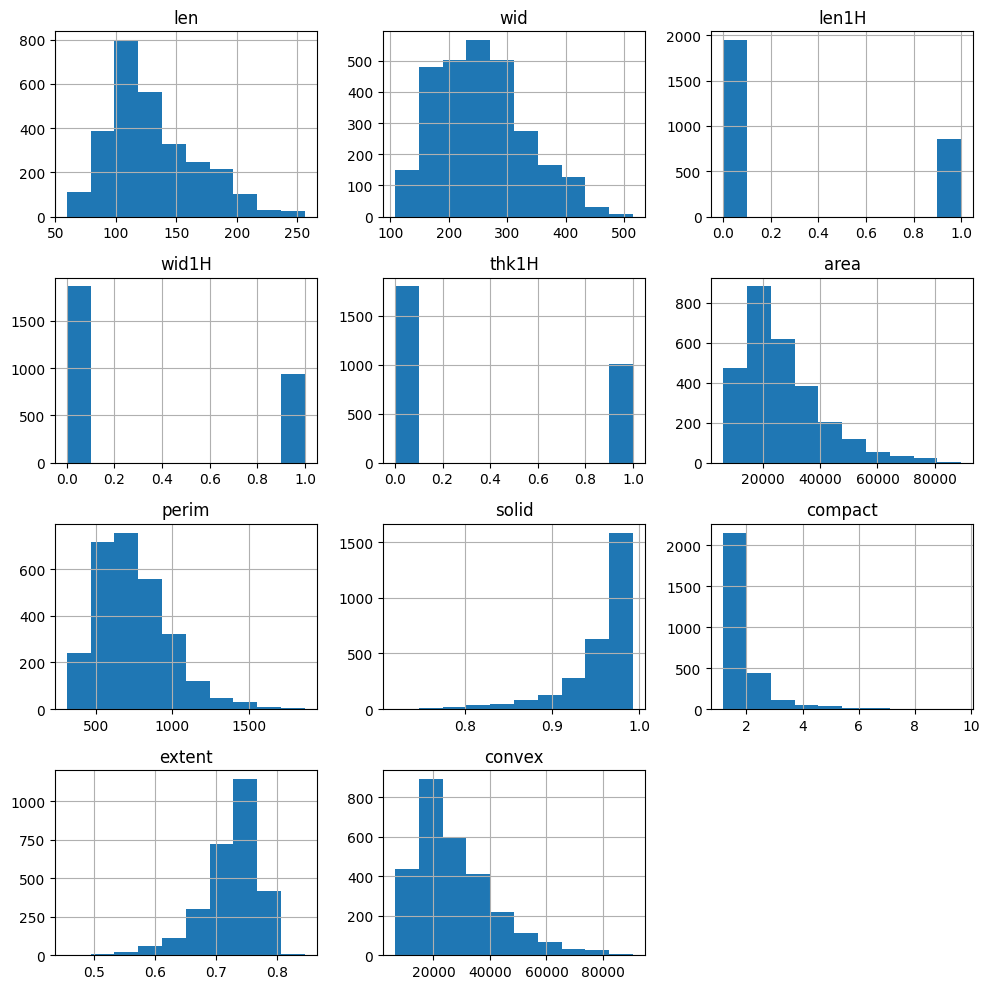

In [3]:
import matplotlib.pyplot as plt
X.hist(figsize=(10, 10))
plt.tight_layout()
plt.title("All attributes")
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

#----- Get compute device -----#
dev = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: \033[0;94m{dev}\033[0m")

#----- Rescale features -----#
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

#----- Split test / training -----#
trainX, testX, trainY, testY = train_test_split(X_scaled, Y.values, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
trainX = torch.tensor(trainX, dtype=torch.float32).to(dev)
trainY = torch.tensor(trainY, dtype=torch.float32).to(dev)
testX = torch.tensor(testX, dtype=torch.float32).to(dev)
testY = torch.tensor(testY, dtype=torch.float32).to(dev)

#----- Define NN -----#
class NeuralNet(nn.Module):
    def __init__(self, inDim, outDim):
        super(NeuralNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(inDim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            # nn.Linear(64, 64), nn.ReLU(),
            # nn.Linear(64, 64), nn.ReLU(),
            # nn.Linear(64, 64), nn.ReLU(),
            # nn.Linear(64, 16), nn.ReLU(),
            # nn.Linear(16, 64), nn.ReLU(),
            nn.Linear(64, outDim)
        )
        # self.fc1 = nn.Linear(inDim, 64)
        # self.fc2 = nn.Linear(64, 32)
        # self.fc3 = nn.Linear(32, outDim)
        # self.relu = nn.ReLU()
    
    def forward(self, x):
        # out = self.relu(self.fc1(x))
        # out = self.relu(self.fc2(out))
        # out = self.fc3(out)
        logits = self.stack(x)
        return logits


input_dim = trainX.shape[1]
output_dim = trainY.shape[1]

model = NeuralNet(input_dim, output_dim).to(dev)

#----- Define loss + optimizer -----#
criterion = nn.MSELoss()
optimizer = optim.Rprop(model.parameters())

#----- Train -----#
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(trainX)
    loss = criterion(outputs, trainY)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [ {epoch+1}/{num_epochs}\t], Loss:\t\033[0;93m{loss.item():.4f}\033[0m')

#----- Evaluate -----#
model.eval()
with torch.no_grad():
    trainPred = model(trainX)
    trainLoss = criterion(trainPred, trainY).item()
    
    testPred = model(testX)
    testLoss = criterion(testPred, testY).item()

    print()
    print(f'Train Loss: \033[0;96m{trainLoss:.4f}\033[0m')
    print(f'Test Loss: \033[0;96m{testLoss:.4f}\033[0m')



Using device: cuda
Epoch [ 10/100	], Loss:	0.1688
Epoch [ 20/100	], Loss:	0.1441
Epoch [ 30/100	], Loss:	0.1264
Epoch [ 40/100	], Loss:	0.1167
Epoch [ 50/100	], Loss:	0.1097
Epoch [ 60/100	], Loss:	0.1043
Epoch [ 70/100	], Loss:	0.1004
Epoch [ 80/100	], Loss:	0.0973
Epoch [ 90/100	], Loss:	0.0949
Epoch [ 100/100	], Loss:	0.0927

Train Loss: 0.0925
Test Loss: 0.1135


In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#----- Get compute device -----#
dev = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: \033[0;94m{dev}\033[0m")

#----- Rescale & Encode features -----#
scaler = StandardScaler()
x = X[['len', 'wid', 'area', 'perim', 'solid', 'compact', 'extent', 'convex']].values
x = scaler.fit_transform(x)

# Add back one-hot encoded missing values
other = X[['len1H', 'wid1H', 'thk1H']]
x = np.concatenate((x, X[['len1H', 'wid1H', 'thk1H']].values), axis=1)

# encoder = LabelEncoder()
# y = encoder.fit_transform(Y)
y = Y.values

#----- Split test / training -----#
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=69)

# Convert to PyTorch tensors
trainX = torch.tensor(trainX, dtype=torch.float32).to(dev)
trainY = torch.tensor(trainY, dtype=torch.float32).to(dev)
testX = torch.tensor(testX, dtype=torch.float32).to(dev)
testY = torch.tensor(testY, dtype=torch.float32).to(dev)

#----- Define NN -----#
class NeuralNet(nn.Module):
    def __init__(self, inDim, outDim):
        super(NeuralNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(inDim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, outDim)
        )
        # self.fc1 = nn.Linear(inDim, 64)
        # self.fc2 = nn.Linear(64, 32)
        # self.fc3 = nn.Linear(32, outDim)
        # self.relu = nn.ReLU()
    
    def forward(self, x):
        # out = self.relu(self.fc1(x))
        # out = self.relu(self.fc2(out))
        # out = self.fc3(out)
        logits = self.stack(x)
        return logits


input_dim = trainX.shape[1]
output_dim = trainY.shape[1]
# output_dim = len(encoder.classes_)

model = NeuralNet(input_dim, output_dim).to(dev)

#----- Define loss + optimizer -----#
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters())

#----- Train -----#
num_epochs = 200
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(trainX)
    loss = criterion(outputs, trainY)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [ {epoch+1}/{num_epochs}\t], Loss:\t\033[0;93m{loss.item():.4f}\033[0m')

#----- Evaluate -----#
from typing import Optional
def metrics(pred, targ1H, confus: Optional[str] = None):
    predLen = pred.shape[0]
    pred1H = np.zeros([predLen, 3]).astype(int)
    pred1H[np.arange(predLen), pred] = 1

    truePos = np.sum(np.logical_and(pred1H == 1, targ1H == 1))
    trueNeg = np.sum(np.logical_and(pred1H == 0, targ1H == 0))
    falsePos = np.sum(np.logical_and(pred1H == 1, targ1H == 0))
    falseNeg = np.sum(np.logical_and(pred1H == 0, targ1H == 1))

    if confus is not None:
        print()
        print(f"\033[0;94mConfusion Matrix ({confus})\033[0m:")
        print("\033[0;107m    True\tFalse\t\033[0m")
        print(f"\033[0;107mPos\033[0m {truePos}   \t{falsePos}")
        print(f"\033[0;107mNeg\033[0m {trueNeg}   \t{falseNeg}")

    precision = truePos / (truePos + falsePos)
    recall = truePos / (truePos + falseNeg)
    accuracy = (truePos + trueNeg) / (truePos + trueNeg + falsePos + falseNeg)
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, accuracy, f1


model.eval()
with torch.no_grad():
    trainPred = model(trainX)
    trainLoss = criterion(trainPred, trainY).item()
    
    testPred = model(testX)
    testLoss = criterion(testPred, testY).item()

    # print()
    # print(f'Train Loss: \033[0;94m{train_loss:.4f}\033[0m')
    # print(f'Test Loss: \033[0;94m{test_loss:.4f}\033[0m')

    trainPred = trainPred.cpu().numpy()
    trainTarg = trainY.cpu().numpy()

    testPred = testPred.cpu().numpy()
    testTarg = testY.cpu().numpy()

    # Convert predictions to class labels
    trainPred = np.argmax(trainPred, axis=1)
    testPred = np.argmax(testPred, axis=1)

    trainPrec, trainRec, trainAcc, trainF1 = metrics(trainPred, trainTarg, confus="Train")
    testPrec, testRec, testAcc, testF1 = metrics(testPred, testTarg, confus="Test")

    # Output metrics
    print()
    print(f"\033[0;94mTrain Metrics\033[0m:")
    print(f"\033[0;94mPrecision:\033[0m {trainPrec:.4f}")
    print(f"\033[0;94mRecall:\033[0m {trainRec:.4f}")
    print(f"\033[0;94mAccuracy:\033[0m {trainAcc:.4f}")
    print(f"\033[0;94mF1 Score:\033[0m {trainF1:.4f}")

    print()
    print(f"\033[0;94mTest Metrics\033[0m:")
    print(f"\033[0;94mPrecision:\033[0m {testPrec:.4f}")
    print(f"\033[0;94mRecall:\033[0m {testRec:.4f}")
    print(f"\033[0;94mAccuracy:\033[0m {testAcc:.4f}")
    print(f"\033[0;94mF1 Score:\033[0m {testF1:.4f}")

Using device: cuda
Epoch [ 10/2000	], Loss:	0.1954
Epoch [ 20/2000	], Loss:	0.1592
Epoch [ 30/2000	], Loss:	0.1329
Epoch [ 40/2000	], Loss:	0.1175
Epoch [ 50/2000	], Loss:	0.1062
Epoch [ 60/2000	], Loss:	0.0959
Epoch [ 70/2000	], Loss:	0.0893
Epoch [ 80/2000	], Loss:	0.0839
Epoch [ 90/2000	], Loss:	0.0805
Epoch [ 100/2000	], Loss:	0.0776
Epoch [ 110/2000	], Loss:	0.0753
Epoch [ 120/2000	], Loss:	0.0734
Epoch [ 130/2000	], Loss:	0.0717
Epoch [ 140/2000	], Loss:	0.0701
Epoch [ 150/2000	], Loss:	0.0688
Epoch [ 160/2000	], Loss:	0.0676
Epoch [ 170/2000	], Loss:	0.0665
Epoch [ 180/2000	], Loss:	0.0657
Epoch [ 190/2000	], Loss:	0.0649
Epoch [ 200/2000	], Loss:	0.0643
Epoch [ 210/2000	], Loss:	0.0636
Epoch [ 220/2000	], Loss:	0.0629
Epoch [ 230/2000	], Loss:	0.0622
Epoch [ 240/2000	], Loss:	0.0616
Epoch [ 250/2000	], Loss:	0.0610
Epoch [ 260/2000	], Loss:	0.0605
Epoch [ 270/2000	], Loss:	0.0602
Epoch [ 280/2000	], Loss:	0.0598
Epoch [ 290/2000	], Loss:	0.0595
Epoch [ 300/2000	], Loss:	0.0591
